## 0: Import the data

In [1]:
import os
os.getcwd()
os.chdir('C:\\Users\\zain.syed\\Desktop\\University of toronto\\3250 - Intro to Data Science\\project\\data\\cardataset')

In [2]:
import pandas as pd
import numpy as np

data= pd.read_csv('data.csv')



In [3]:
data.head(5)

,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


## 1.0: Pre-processing
1.1 Remove and/or Pre-process N/A variables

In [4]:
## Provides a summary of where the N/A values lie
data.isnull().sum()

Make                    0
Model                   0
Year                    0
Engine Fuel Type        3
Engine HP              69
Engine Cylinders       30
Transmission Type       0
Driven_Wheels           0
Number of Doors         6
Market Category      3742
Vehicle Size            0
Vehicle Style           0
highway MPG             0
city mpg                0
Popularity              0
MSRP                    0
dtype: int64

It can be seen that market Category has the highest number of missing variables.
They are changed to 'Other' Category using the FillNa function

In [5]:
## Fills the N/A values in Market Category to other
data['Market Category']=data['Market Category'].fillna('Other')
data['Engine Fuel Type']= data['Engine Fuel Type'].fillna('Other')

In [6]:
## Provides a visual check of pre-processing the variables
data.isnull().sum()

Make                  0
Model                 0
Year                  0
Engine Fuel Type      0
Engine HP            69
Engine Cylinders     30
Transmission Type     0
Driven_Wheels         0
Number of Doors       6
Market Category       0
Vehicle Size          0
Vehicle Style         0
highway MPG           0
city mpg              0
Popularity            0
MSRP                  0
dtype: int64

1.2 Variables are separated into Categorical and Numeric variables;
    Categorical variables would need to be treated on an individual basis (as shown above) whereas the
    missing values for Numeric variables can be replaced with their median/mean values

In [7]:
categorical_variables= ['Make','Model','Engine Fuel Type','Transmission Type','Vehicle Size',
                       'Vehicle Style']
numeric_variables= ['Year','Engine HP','Number of Doors','highway MPG',
                    'city mpg','Popularity','Engine Cylinders']

1.3 Separate MSRP into labels

The data contains all the car data, X = x1,x2,....xn

The MSRP is the actual price of a car that we will be predicting, Y

In [8]:
MSRP= data['MSRP']
data= data.drop('MSRP', axis=1)


#### 2.0 Setup

The first step is to create a Pipeline. 
A pipeline is a sequence of data processing components.
It allows us to simplify data manipulations and transformations.
Two pipelines will be created:
One for Categorical variables and one for Numeric variables

**2.1**: Pipeline setup

In [9]:

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer
from sklearn.pipeline import FeatureUnion


class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

**2.2** Numeric Pipeline

1. The selector selects and transforms the data from a DataFrame to a NumPy Array
2. Imputer replaces missing values with the median value
3. Standard scaler scales the values between 0 and 1

In [10]:

numeric_pipeline= Pipeline([
    ('selector',DataFrameSelector(numeric_variables)),
    ('imputer',Imputer(strategy='median')),
    ('std_scaler', StandardScaler()),
    
])

numeric_data= numeric_pipeline.fit_transform(data)
numeric_data.shape

C:\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


(11914, 7)

**2.3** Categorical Pipeline

1. The selector selects and transforms the data from a DataFrame to a NumPy Array

2. The ***MultilabelBinarizer*** is multiple label version of OneHot encoder.
   It transforms the categorical values into Binary columns of their own.
   This leads to more variables or features but make it easier for Machine learning algorithms to process since they are now encoded as numbers instead of text.
   
   For example the field *Make* would be transformed into:
   
   *Make* = ['Honda','BMW','Toyota'] -> array ([1,0,0],[0,1,0],[0,0,1])
                                      
                                  

Reference:
1. Source: https://stackoverflow.com/questions/46162855/fit-transform-takes-2-positional-arguments-but-3-were-given-with-labelbinarize

In [11]:


from sklearn.base import TransformerMixin #gives fit_transform method for free
from sklearn.preprocessing import MultiLabelBinarizer

class MyLabelBinarizer(TransformerMixin):
    def __init__(self, *args, **kwargs):
        self.encoder = MultiLabelBinarizer(*args, **kwargs)
    def fit(self, x, y=0):
        self.encoder.fit(x)
        return self
    def transform(self, x, y=0):
        return self.encoder.transform(x)

categorical_pipeline= Pipeline([
    ('selector',DataFrameSelector(categorical_variables)),
    ('label_binarizer', MyLabelBinarizer()),
])


categoric_data= categorical_pipeline.fit_transform(data[categorical_variables])

categoric_data.shape



(11914, 995)

**2.4** Full pipeline

***FeatureUnion*** combines the numeric and the categorical transformations into a full pipeline (which contains both, numeric and categorical variables)

In [12]:
full_pipeline= FeatureUnion(transformer_list=
                            [
                           ('num_pipeline', numeric_pipeline),
                           ('cat_pipeline', categorical_pipeline),
                            ])


data_ml_prepared= full_pipeline.fit_transform(data)
data_ml_prepared.shape

(11914, 1002)

1.4 Split into training and test set

In order to avoid overfitting the data and/or avoid a snooping bias, which is training your model on a particular Machine learning model on pre-conceived perceptions on the data, A **Train_test_split** function is used to randomly separate the data into a training set and a test set.

For replication purposes, A random state is chosen and a standard 80:20 ratio between the training and the test sample is selected.

In [13]:
from sklearn.model_selection import train_test_split

train_data, test_data, MSRP_train,MSRP_test= train_test_split(np.array(data_ml_prepared),np.array(MSRP),
                                                              test_size=0.2,random_state=42)

In [14]:
print(train_data.shape,test_data.shape)

(9531, 1002) (2383, 1002)


In [15]:
print(MSRP_train.shape, MSRP_test.shape)

(9531,) (2383,)


In [35]:
## Map data type as float64

train_data= train_data.astype('float64')
test_data= test_data.astype('float64')
MSRP_train= MSRP_train.astype('float64')
MSRP_test= MSRP_test.astype('float64')

##  3.0 Linear regression



3.1 Train the model

In [122]:
from sklearn.linear_model import LinearRegression

lin_reg= LinearRegression(normalize= True, n_jobs=-1,fit_intercept=True)

lin_reg.fit(train_data,MSRP_train)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=True)

3.2 Test the model

In [123]:
from sklearn.metrics import mean_squared_error,r2_score

car_msrp_predictions= lin_reg.predict(test_data)

from sklearn.metrics import mean_squared_error

lin_mse= mean_squared_error(MSRP_test,car_msrp_predictions)
lin_rmse= np.sqrt(lin_mse)

print("Mean Squared Error:",lin_rmse,"\n",
      "R^2 error:",r2_score(MSRP_test,car_msrp_predictions))

Mean Squared Error: 1.765746871492409e+17 
 R^2 error: -1.3080639721426004e+25


Right off the bat, it can be clearly seen that something went wrong.
The mean squared error and the R^2 error are exceptionally high values.



**2.3 Fix issues**:

The first step was to look at the numbers using a scatterplot.

Some interesting instances arose:

1. Outliers:
   Some prediction values were far too high/low:
   - They were exceptionally negative values
   - They were exceptionally large numbers
   
2. Prediction accuracy bad for high car prices and low car prices:
   Our algorithm did not work properly for high car prices, ~ \\$500,000 or low prices ~ $2,000.
A function (**remove_outliers**) was written to extract the outliers and examine them; This would allow us to fine-tune our algorithm. The first 15 outliers are extracted and examined visually

In [130]:
error_df= pd.DataFrame({'y_actual':MSRP_test,
                        'y_predict':car_msrp_predictions})
error_df['% difference']= round(100*(error_df['y_actual'] - error_df['y_predict'])/error_df['y_actual'],1)
error_df

,y_actual,y_predict,% difference
0,29695.0,31496.0,-6.1
1,30495.0,25160.0,17.5
2,37650.0,37768.0,-0.3
3,16170.0,19296.0,-19.3
4,2000.0,6448.0,-222.4
...,...,...,...
2378,35550.0,38160.0,-7.3
2379,48360.0,56944.0,-17.8
2380,31750.0,19736.0,37.8
2381,20995.0,22648.0,-7.9


In [131]:
error_df.sort_values('% difference',ascending=True)

,y_actual,y_predict,% difference
627,2000.0,2.898689e+18,-1.449345e+17
247,2000.0,2.898689e+18,-1.449345e+17
1784,2000.0,2.898689e+18,-1.449345e+17
1780,2000.0,9.670682e+17,-4.835341e+16
1379,36620.0,2.842299e+18,-7.761603e+15
...,...,...,...
1523,82700.0,-1.362378e+16,1.647373e+13
1524,643330.0,-2.295568e+18,3.568259e+14
873,36625.0,-3.857712e+17,1.053300e+15
77,36625.0,-3.857712e+17,1.053300e+15


In [132]:
error_df.sort_values('% difference',ascending=False)

,y_actual,y_predict,% difference
388,5650.0,-7.166165e+17,1.268348e+16
77,36625.0,-3.857712e+17,1.053300e+15
873,36625.0,-3.857712e+17,1.053300e+15
1524,643330.0,-2.295568e+18,3.568259e+14
1523,82700.0,-1.362378e+16,1.647373e+13
...,...,...,...
1379,36620.0,2.842299e+18,-7.761603e+15
1780,2000.0,9.670682e+17,-4.835341e+16
1784,2000.0,2.898689e+18,-1.449345e+17
247,2000.0,2.898689e+18,-1.449345e+17


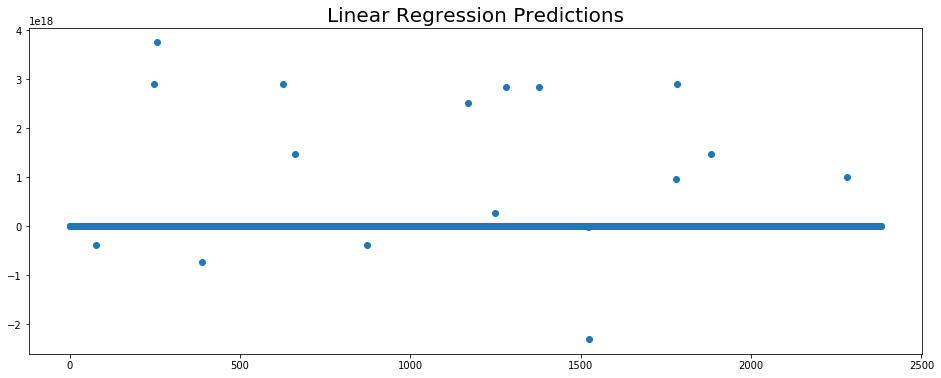

In [137]:
plt.figure(figsize=(16,6))
plt.plot(car_msrp_predictions,'o')


plt.title('Linear Regression Predictions',fontsize=20)

plt.show()


**Solution #1:**
Extracts outliers and their indexes from the data

In [165]:
def show_outliers(data):
    df= pd.DataFrame(data)
    outliers= []
    indexes= []
    
    for i,number in enumerate(data):
        
        if number < 0:
            outliers.append(number)
            indexes.append(i)

        if number > 500000:
            outliers.append(number)
            indexes.append(i)
            
        else: 
            continue 
            
    return indexes,outliers

out, ind= show_outliers(car_msrp_predictions)
print(out[0:5],ind[0:5])

[58, 77, 105, 125, 130] [-232.0, -3.857712140268818e+17, -1480.0, -712.0, -3368.0]


In [175]:
def remove_outliers(data):
    df= pd.DataFrame(data)
    stable_data= []
    indexes= []
    
    for i,number in enumerate(data):
        
        if (number > 0) and (number < 500000):
            stable_data.append(number)
            indexes.append(i)  
        else: 
            continue 
            
    return indexes,stable_data

ind,out= remove_outliers(car_msrp_predictions)


***ind*** gives us the index of our predictions which are stable.

In [179]:
lin_mse= mean_squared_error(MSRP_test[ind],car_msrp_predictions[ind])
lin_rmse= np.sqrt(lin_mse)

print("Mean Squared Error:",lin_rmse,"\n",
      "R^2 error:",r2_score(MSRP_test[ind],car_msrp_predictions[ind]))

Mean Squared Error: 6556.915021211828 
 R^2 error: 0.9800946643708693


**Conclusion**: It can be seen that most of the outliers are negative or positive values. 
We can solve the problem by setting a basic intercept, i.e Car values should start from the minimum car price of $2000.

In [86]:
lin_reg.intercept_

0.0

36625.0

In [54]:
## Car_msrp_predictions changed to an Integer, some loss of accuracy may occur


list(car_msrp_predictions)

[32012.0,
 25284.0,
 38124.0,
 18820.0,
 5804.0,
 14496.0,
 43980.0,
 3236.0,
 5420.0,
 20484.0,
 15188.0,
 3724.0,
 1932.0,
 29088.0,
 27588.0,
 22156.0,
 30944.0,
 34228.0,
 26892.0,
 45740.0,
 14636.0,
 6124.0,
 68008.0,
 25924.0,
 17900.0,
 456352.0,
 39024.0,
 28420.0,
 4492.0,
 37508.0,
 31244.0,
 33856.0,
 26196.0,
 40172.0,
 23884.0,
 56996.0,
 22040.0,
 41772.0,
 41668.0,
 31316.0,
 17796.0,
 31132.0,
 33036.0,
 40340.0,
 22244.0,
 22868.0,
 27820.0,
 53340.0,
 52552.0,
 20320.0,
 49116.0,
 29220.0,
 26768.0,
 22092.0,
 26860.0,
 265260.0,
 2532.0,
 39436.0,
 -396.0,
 25012.0,
 24580.0,
 55668.0,
 22068.0,
 39044.0,
 23012.0,
 38268.0,
 32252.0,
 28036.0,
 43304.0,
 15968.0,
 23948.0,
 20748.0,
 23620.0,
 4060.0,
 28908.0,
 36668.0,
 43220.0,
 -2.260352011285932e+17,
 5780.0,
 4380.0,
 61996.0,
 35820.0,
 12168.0,
 24988.0,
 25528.0,
 47532.0,
 17900.0,
 2760.0,
 14540.0,
 32472.0,
 47592.0,
 29436.0,
 8044.0,
 31880.0,
 50252.0,
 15104.0,
 23260.0,
 17156.0,
 30548.0,
 4076.0

In [40]:
MSRP_test

array([29695., 30495., 37650., ..., 31750., 20995., 57700.])

In [42]:
import matplotlib.pyplot as plt

lin_mse= mean_squared_error(MSRP_test,car_msrp_predictions)
lin_rmse= np.sqrt(lin_mse)

lin_rmse

4232317219319.3604

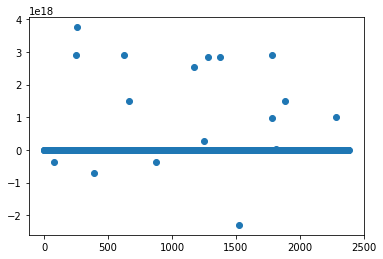

In [135]:
plt.plot(car_msrp_predictions,'o')

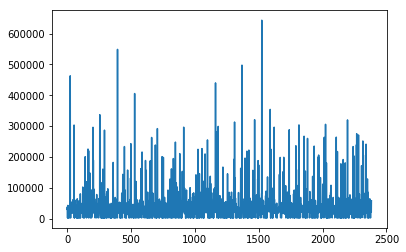

In [44]:
plt.plot(MSRP_test)

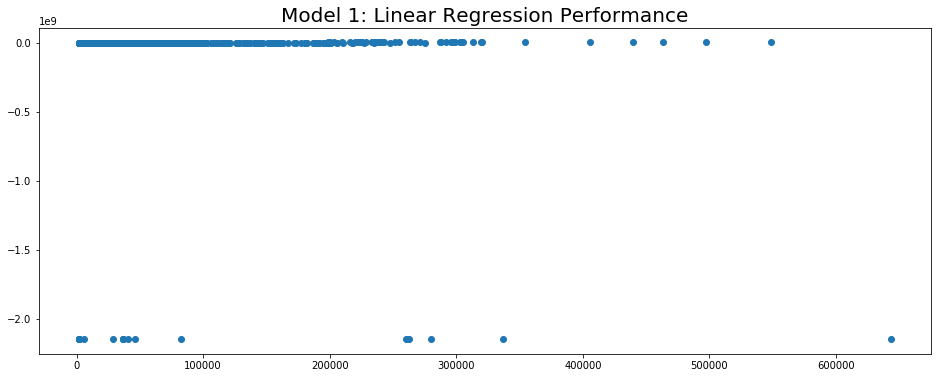

Our linear regression algorithm has an accuracy of ~ $ 5,800. 
In order to improve it, we can:

1. Use a correlation matrix and drop some variables
2. Try out a different algorithm

2.4 Try Ordinary least squares 

Reference:
1. https://stackoverflow.com/questions/38573354/multiple-linear-regression-in-python-patsyerror-model-is-missing-required-outc
2. http://www.statsmodels.org/stable/index.html

In [24]:


import statsmodels.formula.api as smf
#df = pd.DataFrame({'x':train_data, 'y':MSRP_train})
#model = smf.ols('y~x', data=df).fit()


## 3.0 Elastic Net

3.1 Train the model

In [25]:
from sklearn.linear_model import ElasticNet

elastic_net= ElasticNet(alpha=0.1,l1_ratio=0.5)
elastic_net.fit(train_data,MSRP_train)

ElasticNet(alpha=0.1, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

3.2 Test the model

In [62]:
from sklearn.metrics import mean_squared_error

elastic_net_msrp_predictions= elastic_net.predict(test_data)


elastic_mse= mean_squared_error(MSRP_test.astype('int'),elastic_net_msrp_predictions.astype('int'))
elastic_rmse= np.sqrt(elastic_mse)

elastic_rmse

14830.509948705363

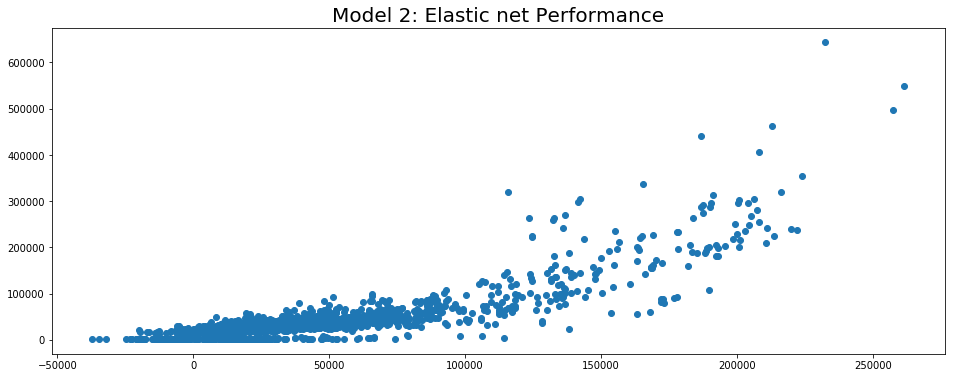

In [63]:
plt.figure(figsize=(16,6))
plt.plot(elastic_net_msrp_predictions.astype('int'),MSRP_test.astype('int'),'o')


plt.title('Model 2: Elastic net Performance',fontsize=20)

plt.show()

**Conclusion**: Elastic net appears to be overfitting the data

In [28]:
MSRP_test

array([29695, 30495, 37650, ..., 31750, 20995, 57700], dtype=int64)

2.3 Build an API to apply pipeline to extract info